In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

pd.set_option('display.max_columns', None)

In [4]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape
import time

import warnings

from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Loading Required Files

## Datasets

In [6]:
df_ts_final = pd.read_csv('./data_artifacts/df_ts_final.csv')
df_ts_final.shape

(37422, 13)

In [39]:
# df_ps_mapped_1to1_geoloc = pd.read_csv('./data_artifacts/df_ps_mapped_1to1_geoloc.csv')
# df_ps_mapped_1to1_geoloc

In [40]:
# Dropping 'Capacity' columns
def drop_cols(reg_train_test_dict, col):

    reg_mod_train_test_dict = {}
    for ps_idx in list(reg_train_test_dict.keys())[:]:

        df_train = reg_train_test_dict[ps_idx]['train']
        df_test = reg_train_test_dict[ps_idx]['test']

        reg_mod_train_test_dict[ps_idx] = {}
        reg_mod_train_test_dict[ps_idx]['train'] = df_train.drop([col], axis=1)
        reg_mod_train_test_dict[ps_idx]['test'] = df_test.drop([col], axis=1)
        
    return reg_mod_train_test_dict
    


with open('./data_artifacts/reg_v1_train_test_dict.pkl', 'rb') as f:
    reg_final_v1_train_test_dict = pickle.load(f)
    
    
reg_final_v1_mod_train_test_dict = drop_cols(reg_train_test_dict=reg_final_v1_train_test_dict, col='Capacity') 
print(reg_final_v1_mod_train_test_dict[1]['train'].shape)
print(reg_final_v1_mod_train_test_dict[1]['test'].shape)

(1260, 14)
(126, 14)


## Scaler

In [47]:
with open('./data_artifacts/fit_std_scaler_dict.pkl', 'rb') as f:
    fit_std_scaler_dict = pickle.load(f)

## Models

In [44]:
with open('./data_artifacts/fit_models_best_dict.pkl', 'rb') as f:
    fit_models_best_dict = pickle.load(f)

# User input

In [109]:
ts_train_test_splitted_dict[3]['test']

TimeStamp
2016-12-13 08:00:00    41.2514
2016-12-13 08:30:00    47.9722
2016-12-13 09:00:00    61.0660
2016-12-13 09:30:00    71.8424
2016-12-13 10:00:00    82.5029
                        ...   
2016-12-19 14:30:00    96.4079
2016-12-19 15:00:00    93.5110
2016-12-19 15:30:00    88.9919
2016-12-19 16:00:00    81.9235
2016-12-19 16:30:00    78.2155
Name: Occupancy_Rate, Length: 126, dtype: float64

In [111]:
test_time_index = ts_train_test_splitted_dict[3]['test'].index
test_time_index[0]

Timestamp('2016-12-13 08:00:00')

In [112]:
user_inp_date = '2016-12-17'
user_inp_time = '15:30'

user_inp_datetime = user_inp_date + ' ' + user_inp_time + ':00'
print(f'User input in datetime: {user_inp_datetime}')

forecast_steps = np.where(test_time_index==pd.to_datetime(user_inp_datetime))[0][0]
print(f'Forecast Steps: {forecast_steps}')

User input in datetime: 2016-12-17 15:30:00
Forecast Steps: 87


In [113]:
test_time_index[87]

Timestamp('2016-12-17 15:30:00')

# Forecast Pipiline

In [114]:
df_train_ps3 = reg_final_v1_mod_train_test_dict[3]['train']
df_train_ps3.tail()

,Year,Month,Day,DayOfWeek,isWeekend,Hour,Minute,Occupancy_Rate,lag_1,lag_2,lag_3,lag_18,lag_19,lag_20
TimeStamp,,,,,,,,,,,,,,
2016-12-12 14:30:00,2016,12,12,0,0,14,30,92.6999,95.1333,95.4809,97.6825,98.6095,99.6524,95.3650
2016-12-12 15:00:00,2016,12,12,0,0,15,0,90.4983,92.6999,95.1333,95.4809,95.3650,98.6095,99.6524
2016-12-12 15:30:00,2016,12,12,0,0,15,30,84.3569,90.4983,92.6999,95.1333,92.3523,95.3650,98.6095
2016-12-12 16:00:00,2016,12,12,0,0,16,0,78.6790,84.3569,90.4983,92.6999,86.7903,92.3523,95.3650
2016-12-12 16:30:00,2016,12,12,0,0,16,30,71.1472,78.6790,84.3569,90.4983,78.4473,86.7903,92.3523


In [115]:
std_scaler_ps3 = fit_std_scaler_dict[3]
xgbr_ps3 = fit_models_best_dict[3]

In [129]:
sample_ts = test_time_index[0]

sample_year = sample_ts.year
sample_month = sample_ts.month
sample_day = sample_ts.day
sample_dayOfWeek = sample_ts.dayofweek
sample_isWeekend = 1 if sample_dayOfWeek in [5, 6] else 0
sample_hour = sample_ts.hour
sample_minute = sample_ts.minute
# print(sample_year, sample_month, sample_day, sample_dayOfWeek, sample_isWeekend, sample_hour, sample_minute)

occu_rt_lag1 = df_train_ps3.iloc[-1].loc['Occupancy_Rate']
occu_rt_lag2 = df_train_ps3.iloc[-2].loc['Occupancy_Rate']
occu_rt_lag3 = df_train_ps3.iloc[-3].loc['Occupancy_Rate']
occu_rt_lag18 = df_train_ps3.iloc[-18].loc['Occupancy_Rate']
occu_rt_lag19 = df_train_ps3.iloc[-19].loc['Occupancy_Rate']
occu_rt_lag20 = df_train_ps3.iloc[-20].loc['Occupancy_Rate']




df_sample = pd.DataFrame(index=[sample_ts], data={'Year':[sample_year], 'Month':[sample_month], 'Day':[sample_day], 
                                                  'DayOfWeek':[sample_dayOfWeek], 'isWeekend':[sample_isWeekend], 
                                                  'Hour':[sample_hour], 'Minute':[sample_minute], 
                                                  'lag_1':[occu_rt_lag1], 'lag_2':[occu_rt_lag2], 'lag_3':[occu_rt_lag3], 
                                                  'lag_18':[occu_rt_lag18], 'lag_19':[occu_rt_lag19],'lag_20':[occu_rt_lag20]})

X_sample_scl = std_scaler_ps3.transform(df_sample)
print(df_sample.shape)
print(X_sample_scl.shape)

pred_sample = xgbr_ps3.predict(X_sample_scl)
pred_sample = 0 if pred_sample<0 else (100 if pred_sample>100 else pred_sample)
print(pred_sample)


df_sample['Occupancy_Rate'] = pred_sample

df_appended = pd.concat([df_train_ps3, df_sample], axis=0)
df_appended.tail()

(1, 13)
(1, 13)
[45.393787]


,Year,Month,Day,DayOfWeek,isWeekend,Hour,Minute,Occupancy_Rate,lag_1,lag_2,lag_3,lag_18,lag_19,lag_20
2016-12-12 15:00:00,2016,12,12,0,0,15,0,90.498300,92.6999,95.1333,95.4809,95.3650,98.6095,99.6524
2016-12-12 15:30:00,2016,12,12,0,0,15,30,84.356900,90.4983,92.6999,95.1333,92.3523,95.3650,98.6095
2016-12-12 16:00:00,2016,12,12,0,0,16,0,78.679000,84.3569,90.4983,92.6999,86.7903,92.3523,95.3650
2016-12-12 16:30:00,2016,12,12,0,0,16,30,71.147200,78.6790,84.3569,90.4983,78.4473,86.7903,92.3523
2016-12-13 08:00:00,2016,12,13,1,0,8,0,45.393787,71.1472,78.6790,84.3569,42.7578,78.4473,86.7903


In [128]:
df_train_ps3.tail()

,Year,Month,Day,DayOfWeek,isWeekend,Hour,Minute,Occupancy_Rate,lag_1,lag_2,lag_3,lag_18,lag_19,lag_20
TimeStamp,,,,,,,,,,,,,,
2016-12-12 14:30:00,2016,12,12,0,0,14,30,92.6999,95.1333,95.4809,97.6825,98.6095,99.6524,95.3650
2016-12-12 15:00:00,2016,12,12,0,0,15,0,90.4983,92.6999,95.1333,95.4809,95.3650,98.6095,99.6524
2016-12-12 15:30:00,2016,12,12,0,0,15,30,84.3569,90.4983,92.6999,95.1333,92.3523,95.3650,98.6095
2016-12-12 16:00:00,2016,12,12,0,0,16,0,78.6790,84.3569,90.4983,92.6999,86.7903,92.3523,95.3650
2016-12-12 16:30:00,2016,12,12,0,0,16,30,71.1472,78.6790,84.3569,90.4983,78.4473,86.7903,92.3523


In [133]:
def xgbr_forecast(steps, forecast_index_list, df_org, std_scaler, model):
    
    df_appended = df_org.copy()
    
    for step in range(0, steps):
        # print(forecast_index_list[step])
        
        # Get timestamp to predict for
        sample_ts = forecast_index_list[step]

        # Get temporal features
        sample_year = sample_ts.year
        sample_month = sample_ts.month
        sample_day = sample_ts.day
        sample_dayOfWeek = sample_ts.dayofweek
        sample_isWeekend = 1 if sample_dayOfWeek in [5, 6] else 0
        sample_hour = sample_ts.hour
        sample_minute = sample_ts.minute
        
        # DEBUG:
        # print(sample_year, sample_month, sample_day, sample_dayOfWeek, sample_isWeekend, sample_hour, sample_minute)

        # Get lag features
        occu_rt_lag1 = df_appended.iloc[-1].loc['Occupancy_Rate']
        occu_rt_lag2 = df_appended.iloc[-2].loc['Occupancy_Rate']
        occu_rt_lag3 = df_appended.iloc[-3].loc['Occupancy_Rate']
        occu_rt_lag18 = df_appended.iloc[-18].loc['Occupancy_Rate']
        occu_rt_lag19 = df_appended.iloc[-19].loc['Occupancy_Rate']
        occu_rt_lag20 = df_appended.iloc[-20].loc['Occupancy_Rate']

        
        # Framing the dataframe for predict sample
        df_sample = pd.DataFrame(index=[sample_ts], data={'Year':[sample_year], 'Month':[sample_month], 'Day':[sample_day], 
                                                          'DayOfWeek':[sample_dayOfWeek], 'isWeekend':[sample_isWeekend], 
                                                          'Hour':[sample_hour], 'Minute':[sample_minute], 
                                                          'lag_1':[occu_rt_lag1], 'lag_2':[occu_rt_lag2], 'lag_3':[occu_rt_lag3], 
                                                          'lag_18':[occu_rt_lag18], 'lag_19':[occu_rt_lag19],'lag_20':[occu_rt_lag20]})
        
        
        # Scaling the predict sample
        X_sample_scl = std_scaler.transform(df_sample)
        
        # DEBUG:
        # print(df_sample.shape)
        # print(X_sample_scl.shape)
        
        # Get the prediction out
        pred_sample = model.predict(X_sample_scl)
        pred_sample = 0 if pred_sample<0 else (100 if pred_sample>100 else pred_sample) # Cap the output to 0% & 100%
        
        # DEBUG:
        # print(pred_sample)
        
        
        # Add the predicted output to the dataframe so that future points can be predicted
        df_sample['Occupancy_Rate'] = pred_sample
        
    
        # Concatenating to the tail of the original time series 
        df_appended = pd.concat([df_appended, df_sample], axis=0)
        
    
    return df_appended
        
        
               
df_forecasted = xgbr_forecast(steps=36, forecast_index_list=test_time_index, df_org=df_train_ps3, 
                              std_scaler=std_scaler_ps3, model=xgbr_ps3)

df_forecasted.tail()

,Year,Month,Day,DayOfWeek,isWeekend,Hour,Minute,Occupancy_Rate,lag_1,lag_2,lag_3,lag_18,lag_19,lag_20
2016-12-14 14:30:00,2016,12,14,2,0,14,30,93.416870,95.133942,97.102310,97.901627,93.416870,95.133942,97.102310
2016-12-14 15:00:00,2016,12,14,2,0,15,0,88.715660,93.416870,95.133942,97.102310,88.715660,93.416870,95.133942
2016-12-14 15:30:00,2016,12,14,2,0,15,30,85.068794,88.715660,93.416870,95.133942,85.068794,88.715660,93.416870
2016-12-14 16:00:00,2016,12,14,2,0,16,0,79.755821,85.068794,88.715660,93.416870,79.755821,85.068794,88.715660
2016-12-14 16:30:00,2016,12,14,2,0,16,30,72.818817,79.755821,85.068794,88.715660,73.126022,79.755821,85.068794


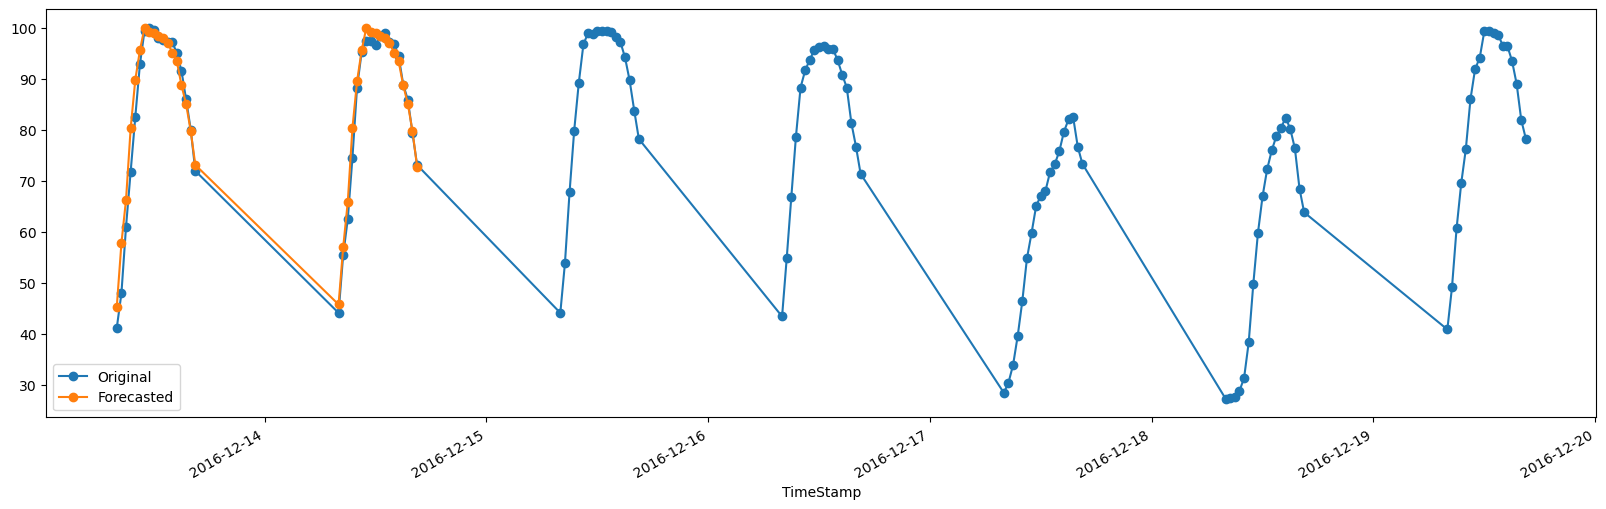

In [146]:
plt.figure(figsize=(20, 6))
reg_final_v1_mod_train_test_dict[3]['test'].Occupancy_Rate.plot(marker='o', label='Original')
df_forecasted.Occupancy_Rate.iloc[-36:].plot(marker='o', label='Forecasted')
plt.legend()
plt.show()

In [158]:
def forecast_all_parklots(steps, forecast_index_list_inp, reg_train_test_dict, std_scaler_dict, xgbr_model_dict):
    
    predicted_dict = {}
    
    for ps_idx in list(reg_final_v1_mod_train_test_dict.keys())[:1]:
        
        df_train_ps = reg_train_test_dict[ps_idx]['train']
        std_scaler = std_scaler_dict[ps_idx]
        xgbr_model = xgbr_model_dict[ps_idx]
        
        # Get forecast
        df_forecasted = xgbr_forecast(steps=steps, 
                                      forecast_index_list=forecast_index_list_inp, 
                                      df_org=df_train_ps, 
                                      std_scaler=std_scaler, 
                                      model=xgbr_model)
        
        
        # Save the forecasted values
        predicted_dict[ps_idx] = {}
        predicted_dict[ps_idx]['train'] = df_forecasted['Occupancy_Rate'].iloc[:-steps]
        predicted_dict[ps_idx]['forecast'] = df_forecasted['Occupancy_Rate'].iloc[-steps:]
        predicted_dict[ps_idx]['test'] = reg_train_test_dict[ps_idx]['test']['Occupancy_Rate']
        
    return predicted_dict

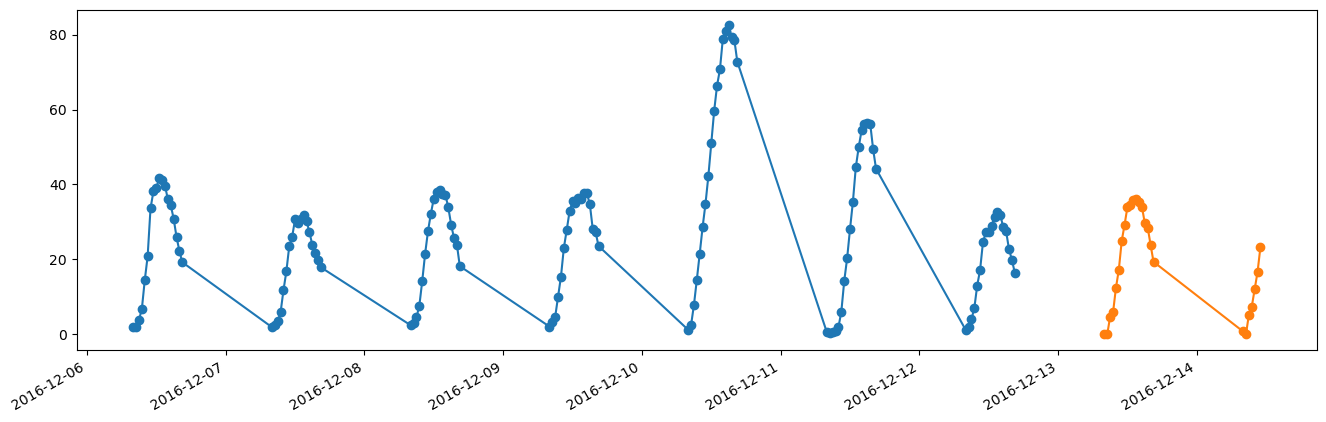

In [167]:
forecasted_dict = forecast_all_parklots(steps=25, 
                                        forecast_index_list_inp=test_time_index, 
                                        reg_train_test_dict=reg_final_v1_mod_train_test_dict, 
                                        std_scaler_dict=fit_std_scaler_dict, 
                                        xgbr_model_dict=fit_models_best_dict)

plt.figure(figsize=(16, 5))
# forecasted_dict[1]['test'].plot(marker='o')
forecasted_dict[1]['train'].iloc[-126:].plot(marker='o')
forecasted_dict[1]['forecast'].plot(marker='o')
plt.show()

<Axes: xlabel='TimeStamp'>

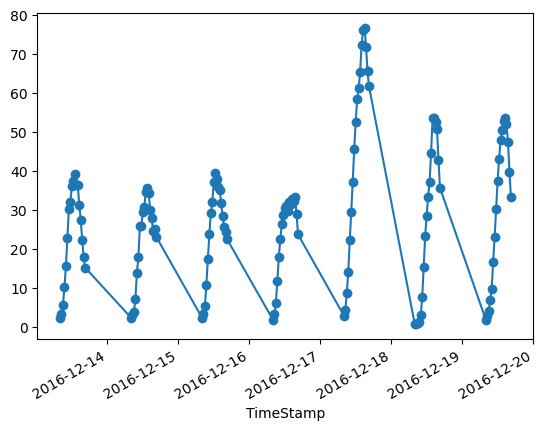

In [147]:
test_time_index

DatetimeIndex(['2016-12-13 08:00:00', '2016-12-13 08:30:00',
               '2016-12-13 09:00:00', '2016-12-13 09:30:00',
               '2016-12-13 10:00:00', '2016-12-13 10:30:00',
               '2016-12-13 11:00:00', '2016-12-13 11:30:00',
               '2016-12-13 12:00:00', '2016-12-13 12:30:00',
               ...
               '2016-12-19 12:00:00', '2016-12-19 12:30:00',
               '2016-12-19 13:00:00', '2016-12-19 13:30:00',
               '2016-12-19 14:00:00', '2016-12-19 14:30:00',
               '2016-12-19 15:00:00', '2016-12-19 15:30:00',
               '2016-12-19 16:00:00', '2016-12-19 16:30:00'],
              dtype='datetime64[ns]', name='TimeStamp', length=126, freq=None)

In [ ]:
reg_final_v1_mod_train_test_dict

In [148]:
fit_std_scaler_dict

{1: StandardScaler(),
 2: StandardScaler(),
 3: StandardScaler(),
 4: StandardScaler(),
 5: StandardScaler(),
 6: StandardScaler(),
 7: StandardScaler(),
 8: StandardScaler(),
 9: StandardScaler(),
 10: StandardScaler(),
 11: StandardScaler(),
 12: StandardScaler(),
 13: StandardScaler(),
 14: StandardScaler(),
 15: StandardScaler(),
 16: StandardScaler(),
 17: StandardScaler(),
 18: StandardScaler(),
 19: StandardScaler(),
 20: StandardScaler(),
 21: StandardScaler(),
 22: StandardScaler(),
 23: StandardScaler(),
 24: StandardScaler(),
 25: StandardScaler(),
 26: StandardScaler(),
 27: StandardScaler()}

In [149]:
fit_models_best_dict

{1: XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 2: XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eva